In [1]:
import matplotlib.pyplot as plt
import numpy as np

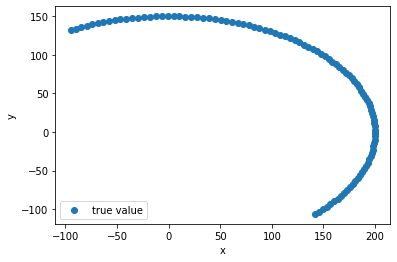

In [4]:
# 課題 2
class Kadai2:
    def __init__(self, n):
        self.n = n  # n=100
        self.theta = -np.pi/4 + (11*np.pi/(12*self.n)*np.arange(0, n))
        self.xv = 200*np.cos(self.theta)
        self.yv = 150*np.sin(self.theta)
    def out_fig(self, filename):
        plt.scatter(self.xv, self.yv, label='true value')
        plt.xlabel("x"), plt.ylabel("y")
        plt.legend(loc='lower left')
        #plt.savefig(filename)
k2 = Kadai2(100)
k2.out_fig(filename='./fig1.pdf')

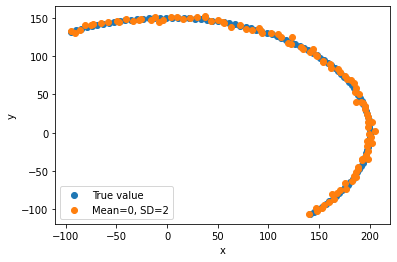

In [5]:
# 課題 3
class Kadai3:
    def __init__(self, k2):
        self.k2 = k2
        self.xv = np.copy(self.k2.xv)
        self.yv = np.copy(self.k2.yv)
        self.xv += np.random.normal(loc=0, scale=2, size=self.k2.n) # 誤差の付与
        self.yv += np.random.normal(loc=0, scale=2, size=self.k2.n) # 誤差の付与
    def out_fig(self, filename):
        plt.clf()
        plt.scatter(self.k2.xv, self.k2.yv, label='True value')
        plt.scatter(self.xv, self.yv, label='Mean=0, SD=2')
        plt.xlabel("x"), plt.ylabel("y")
        plt.legend(loc='lower left')
        #plt.savefig(filename)
k3 = Kadai3(k2)
k3.out_fig(filename='./fig2.pdf')

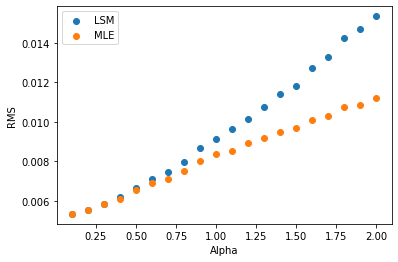

In [6]:
# 課題 4
class Kadai4:
    def __init__(self, k3, epoch):
        self.k3 = k3
        self.epoch = epoch
        self.sigmas = np.arange(start=0.1, stop=2.1, step=0.1)
        self.RMS_LSM = np.zeros(self.sigmas.shape)
        self.RMS_MLE = np.zeros(self.sigmas.shape)
        self.u_true = np.array([[(1/150)**2, 0, (1/200)**2, 0, 0, -1]])
        for j, sigma in enumerate(self.sigmas): # 20週
            for _ in range(self.epoch):      # 1000週 (同じsigmaで1000週)
                xv = np.copy(self.k3.k2.xv)
                yv = np.copy(self.k3.k2.yv)
                xv += np.random.normal(loc=0, scale=sigma, size=self.k3.k2.n)
                yv += np.random.normal(loc=0, scale=sigma, size=self.k3.k2.n)
                u_LSM = self.calc_LSM(xv, yv) # パラメータ推定 (最小二乗法)
                u_MLE = self.calc_MLE(xv, yv) # パラメータ推定 (最尤推定法)
                self.RMS_LSM[j] += self.calc_RMS(u_LSM, self.u_true) / self.epoch
                self.RMS_MLE[j] += self.calc_RMS(u_MLE, self.u_true) / self.epoch
    
    def calc_RMS(self, u_esti, u_true):
        Pu = np.eye(u_true.shape[1]) - u_true.T.dot(u_true)
        delta_u = Pu.dot(u_esti)
        return np.linalg.norm(delta_u, ord=2)
    
    # 最小二乗法
    def calc_LSM(self, xv, yv):
        M = self.calc_M_LSM(xv, yv)
        val, vec = np.linalg.eig(M)
        index = np.abs(val).argsort()[0]    # 昇順にソートした時のindexを取得([0]は最も小さい値の添字)
        u = np.atleast_2d(vec[:, index]).T  # 最も小さい固有値の固有ベクトルを取り出す
        return u

    # 最尤推定
    def calc_MLE(self, xv, yv):
        u = np.zeros((6, 1))  # パラメータベクトル u の初期値
        u0 = np.zeros((6, 1)) # パラメータベクトル u のひとつ前の反復計算の結果
        while True:
            M = self.calc_M_MLE(xv, yv, u0)
            L = self.calc_L(xv, yv, u0)
            val, vec = np.linalg.eig(M - L)
            index = np.abs(val).argsort()[0]    # 昇順にソートした時のindexを取得([0]は最も小さい値の添字)
            u = np.atleast_2d(vec[:, index]).T  # 最も小さい固有値の固有ベクトルを取り出す
            # 誤差が閾値以下になったら終了
            if np.linalg.norm(u0-u, ord=2) < 0.00001:
                # print("deb 1", np.linalg.norm(u0-u, ord=2))
                break
            u0 = u
        return u

    # 最小二乗法で使うM
    def calc_M_LSM(self, xv, yv):
        M = np.zeros((6, 6))
        for xi, yi in zip(xv, yv):
            xi_a = self.calc_xi_a(xi, yi)
            M += xi_a.dot(xi_a.T)
        return M

    # 最尤推定で使うM
    def calc_M_MLE(self, xv, yv, u):
        M = np.zeros((6, 6))
        for xi, yi in zip(xv, yv):
            xi_a = self.calc_xi_a(xi, yi)
            V = self.calc_V(xi, yi)
            if u.T.dot(V.dot(u)) == 0:
                M += xi_a.dot(xi_a.T)
            else:
                M += xi_a.dot(xi_a.T) / u.T.dot(V.dot(u))
        return M
    def calc_L(self, xv, yv, u):
        L = np.zeros((6, 6))
        for xi, yi in zip(xv, yv):
            xi_a = self.calc_xi_a(xi, yi)
            V = self.calc_V(xi, yi)
            if u.T.dot(V.dot(u)) == 0:
                L += (xi_a.T.dot(u))**2 * V
            else:
                L += (xi_a.T.dot(u))**2 * V / u.T.dot(V.dot(u))**2
        return L
    def calc_xi_a(self, xi, yi):
        return np.array([[xi**2, 2*xi*yi, yi**2, 2*xi, 2*yi, 1]]).T
    def calc_V(self, xi, yi):
        return np.array([
            [xi**2, xi*yi,       0,     xi, 0,  0],
            [xi*yi, xi**2+yi**2, xi*yi, yi, xi, 0],
            [0,     xi*yi,       yi**2, 0,  yi, 0],
            [xi,    yi,          0,     1,  0,  0],
            [0,     xi,          yi,    0,  1,  0],
            [0,     0,           0,     0,  0,  0]
        ])

    def out_fig(self, filename):
        plt.clf()
        plt.xlabel("Alpha"), plt.ylabel("RMS")
        plt.scatter(self.sigmas, np.sqrt(self.RMS_LSM), label='LSM')
        plt.scatter(self.sigmas, np.sqrt(self.RMS_MLE), label='MLE')
        plt.legend()
        plt.savefig(filename)
k4 = Kadai4(k3, epoch=1000)
k4.out_fig(filename='./fig3.pdf')


In [ ]:
# 課題 5
class Kadai5:
    def __init__(self, k4):
        self.k4 = k4
        self.KCR = self.calc_KCR(self.k4.sigmas)
    
    def calc_M_KCR(self, xv, yv, u_true):
        M = np.zeros((6, 6))
        u = u_true
        for xi, yi in zip(xv, yv):
            V = self.k4.calc_V(xi, yi)
            xi_a = self.k4.calc_xi_a(xi, yi)
            M += xi_a.dot(xi_a.T) / u.dot(V.dot(u.T))
        return M
    
    def calc_KCR(self, sigmas):
        kcr = np.zeros(self.k4.sigmas.shape)
        self.M = self.calc_M_KCR(self.k4.k3.k2.xv, self.k4.k3.k2.yv, self.k4.u_true)
        vals = np.linalg.eigvals(self.M)
        kcr = np.sqrt(1 / np.sum(vals[0:5]) )
        return sigmas * kcr
    
    def out_fig(self, filename):
        plt.clf()
        plt.xlabel("Alpha"), plt.ylabel("RMS")
        plt.scatter(self.k4.sigmas, np.sqrt(self.k4.RMS_LSM), label='LSM')
        plt.scatter(self.k4.sigmas, np.sqrt(self.k4.RMS_MLE), label='MLE')
        plt.scatter(self.k4.sigmas, self.KCR, label='KCR')
        plt.legend()
        plt.savefig(filename)
k5 = Kadai5(k4)
k5.out_fig(filename='./fig4.pdf')
